In [27]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Convergence diagnostics

Has our simulated Markov chain converged to its stationary distribution yet?

### 1. Trace plots

Our first visual tool for assessing chains is the trace plot. A trace plot shows the history of a parameter value across iterations of the chain. It shows you precisely where the chain has been exploring.

In [28]:
# Log function proportional to the posterior
def log_function(mu, n, y_bar):
    mu2 = mu**2
    return n * (y_bar * mu - mu2 / 2.0) - np.log(1 + mu2)

In [29]:
from scipy.stats import norm
from scipy.stats import uniform

def random_walk_sampler(n, y_bar, n_iter, mu_init, cand_sd):
    ## Random-Walk Metropolis-Hastings algorithm

    ## Step 1, initialize
    mu_out = [] # Output vector
    accpt = 0 # Number of samples accepted
    mu_now = mu_init # Initial state
    lg_now = log_function(mu = mu_now, n = n, y_bar = y_bar) # Current function value

    ## Step 2, iterate
    for i in range(n_iter):
        ## Step 2a
        mu_cand = norm.rvs(size=1, loc = mu_now, scale = cand_sd)[0] # draw a candidate

        ## Step 2b
        lg_cand = log_function(mu = mu_cand, n = n, y_bar = y_bar) # evaluate log of g with the candidate
        lalpha = lg_cand - lg_now # log of acceptance ratio
        alpha = np.exp(lalpha)

        ## Step 2c
        u = uniform.rvs(size = 1)[0] # draw a uniform variable which will be less than alpha with probability min(1, alpha)
        if (u < alpha): # then accept the candidate
            mu_now = mu_cand
            accpt = accpt + 1 # to keep track of acceptance
            lg_now = lg_cand

        ## collect results
        mu_out.append(mu_now) # save this iteration's value of mu

    return mu_out, accpt / n_iter

In [30]:
from scipy.stats import t

y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9]) # Data
y_bar = np.mean(y) # Sample mean
n = y.shape[0] # Data points

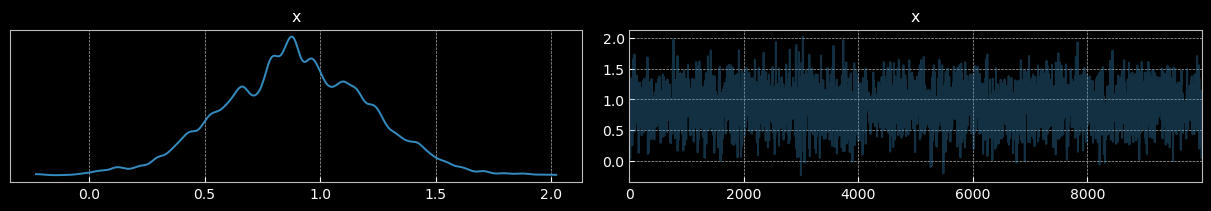

In [31]:
np.random.seed(43) # set the random seed for reproducibility
it = int(10e3)
samples_1, aceptance_1 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 0.0, cand_sd = 0.9)

# Plotting posterior distribution of mu
az.plot_trace(np.array(samples_1))
plt.show()

If the chain is stationary, it should not be showing any long-term trends. The average value for the chain should be roughly flat. It should not be wandering as in this example:

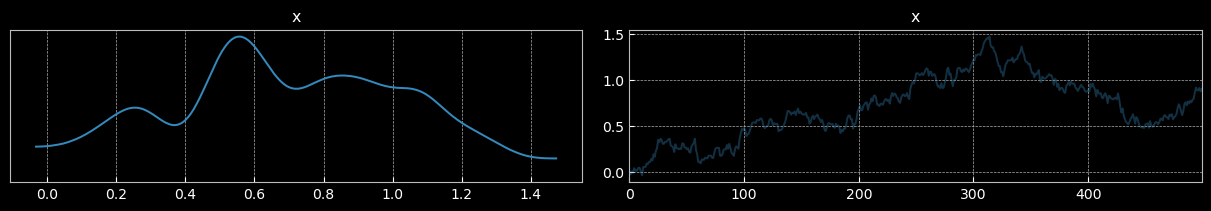

In [32]:
# Wanderer chain
np.random.seed(43) # set the random seed for reproducibility
it = int(1e3)
samples_2, aceptance_2 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 0.0, cand_sd = 0.04)

# Plotting posterior distribution of mu
az.plot_trace(np.array(samples_2[:500]))
plt.show()

In the last case, you need to run the chain many more iterations

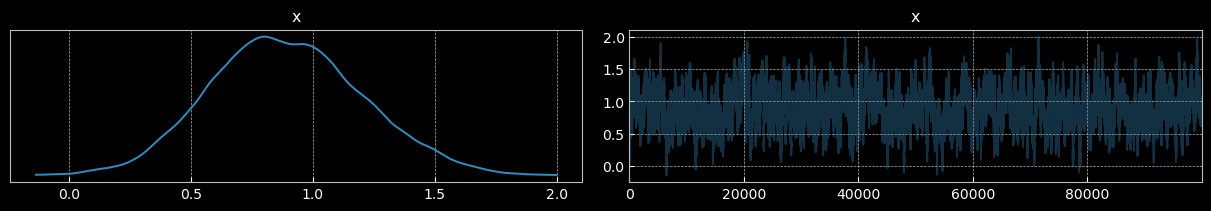

In [33]:
# Wanderer chain
np.random.seed(43) # set the random seed for reproducibility
it = int(100e3)
samples_3, aceptance_3 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 0.0, cand_sd = 0.04)

# Plotting posterior distribution of mu
az.plot_trace(np.array(samples_3))
plt.show()

### 2. Monte Carlo effective sample size

One major difference between the two chains we’ve looked at is the level of autocorrelation in each. Autocorrelation is a number between $−1$ and $+1$ which measures how linearly dependent the current value of the chain is on past values (called lags).

Autocorrelation of first chain.

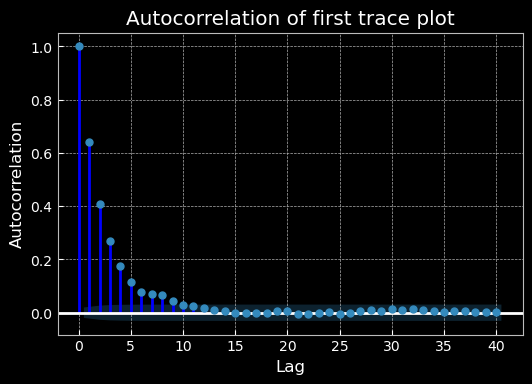

The first autocorrelation values are: [1.         0.6419028  0.40960726 0.26782223 0.17496527]


In [34]:
# Plot autocorrelation
sm.graphics.tsa.plot_acf(samples_1, lags=40, vlines_kwargs = {"colors": 'blue'})
# Add labels to autocorrelation plot
plt.title('Autocorrelation of first trace plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
# Display the autocorrelation plot
plt.show()

# Compute autocorrelation vector
autocorr = stattools.acf(samples_1)
print('The first autocorrelation values are: {}'.format(autocorr[:5]))

At the beginning there is a very high correclation. Later, this start decreasing.

Autocorrelation of second chain.

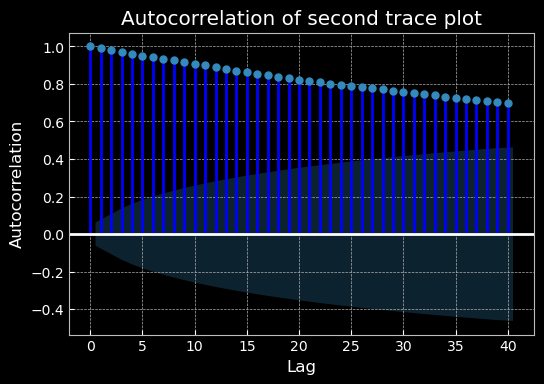

The first autocorrelation values are: [1.         0.99057992 0.98035821 0.97022153 0.96003921]


In [35]:
# Plot autocorrelation
sm.graphics.tsa.plot_acf(samples_2, lags=40, vlines_kwargs = {"colors": 'blue'})
# Add labels to autocorrelation plot
plt.title('Autocorrelation of second trace plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
# Display the autocorrelation plot
plt.show()

# Compute autocorrelation vector
autocorr = stattools.acf(samples_2)
print('The first autocorrelation values are: {}'.format(autocorr[:5]))

Autocorrelation is important because it tells us how much information is available in our Markov chain. Sampling 1000 iterations from a highly correlated Markov chain yields less information about the stationary distribution than we would obtain from 1000 samples independently drawn from the stationary distribution. Therefore, the first chain is better!

Autocorrelation is a major component in calculating the Monte Carlo effective sample size of your chain. The Monte Carlo effective sample size is how many independent samples from the stationary distribution you would have to draw to have equivalent information in your Markov chain. 

The first 3 samples of the chain are: [0.010295997013787734, -0.026043260297438704, 0.008279673545426303]
The acceptance rate is: 0.95863
The effective sample size of this chain is: 361.90763832397136


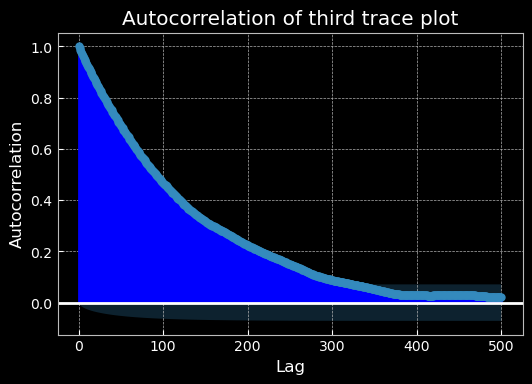

In [36]:
print('The first 3 samples of the chain are: {}'.format(samples_3[:3]))
print('The acceptance rate is: {}'.format(aceptance_3))
ess = az.ess(np.array(samples_3))
print('The effective sample size of this chain is: {}'.format(ess))

# Plot autocorrelation
sm.graphics.tsa.plot_acf(samples_3, lags=500, vlines_kwargs = {"colors": 'blue'})
# Add labels to autocorrelation plot
plt.title('Autocorrelation of third trace plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
# Display the autocorrelation plot
plt.show()
## Thin out the samples until autocorrelation is essentially 0. This will leave you with approximately independent samples. The number of samples remaining is similar to the effective sample size.

This plot shows us that you have to go all the way out to about $400$ lags or even further than $400$ lags before auto correlation drops to 0. In other words, values in the chain have to be about $400$ steps apart from each other before there are no longer autocorrelated with each other.

What happen if we keep one of every $400$ iterations?

The first 5 index are: [ 400  800 1200 1600 2000]


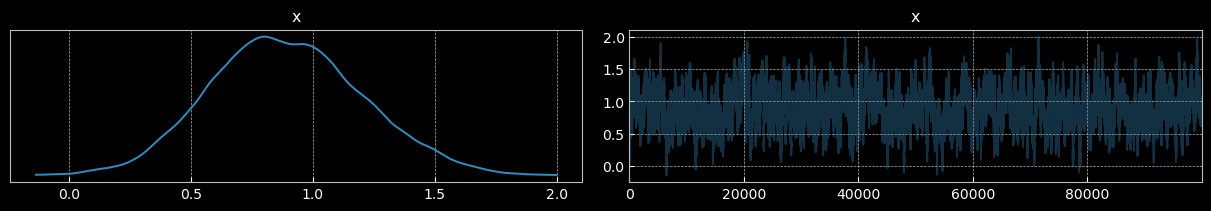

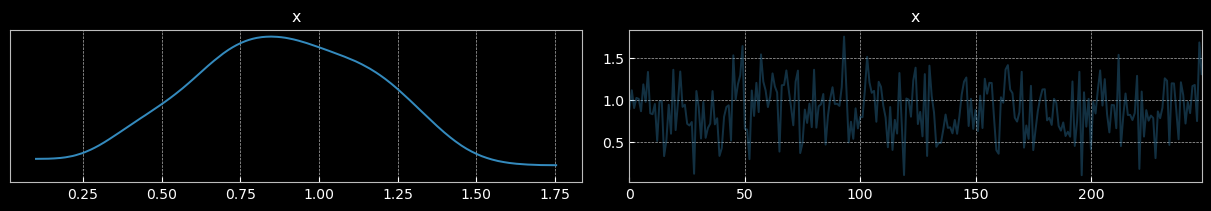

In [37]:
thin_interval = 400 # how far apart the iterations are for autocorrelation to be essentially 0.
thin_indx = np.arange(thin_interval, len(samples_3), thin_interval)
print('The first 5 index are: {}'.format(thin_indx[:5]))

post2mu_thin = np.array(samples_3)[thin_indx]
# Plotting the original chain
az.plot_trace(np.array(samples_3))
plt.show()
# Plotting the samples chain
az.plot_trace(post2mu_thin)
plt.show()

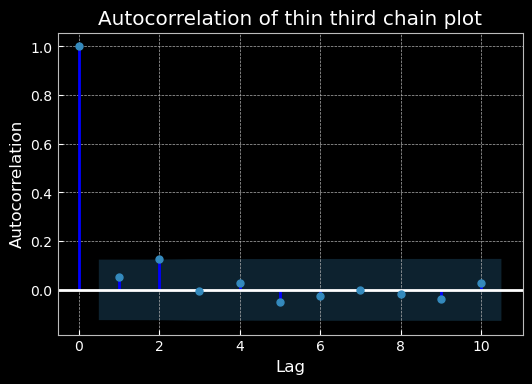

The effective sample size of the thin chain is: 188.09806478997285
The current lenght of the chain is: (249,)


In [38]:
# Plot autocorrelation pf thin chain
sm.graphics.tsa.plot_acf(post2mu_thin, lags=10, vlines_kwargs = {"colors": 'blue'})
# Add labels to autocorrelation plot
plt.title('Autocorrelation of thin third chain plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
# Display the autocorrelation plot
plt.show()

ess = az.ess(post2mu_thin)
print('The effective sample size of the thin chain is: {}'.format(ess))
print('The current lenght of the chain is: {}'.format(post2mu_thin.shape))

The auto correlation has essentially disappeared if we've thinned the chain out to every $400$ iterations. Additionally, the effective sample size are more similar as the correlation has dropped a lot.

We've now discussed two different interpretations of the effective sample size. The effective sample size can be thought of as how many independent samples you would need to get the same information or you could think of it as the length of chain you would have left over if you removed iterations or thinned the chain until you got rid of the auto correlation. 

### Analyzing first chain

In [39]:
print('The first 3 samples of the first chain are: {}'.format(samples_1[:3]))
print('The acceptance rate is: {}'.format(aceptance_1))
ess = az.ess(np.array(samples_1))
print('The effective sample size of this chain is: {}'.format(ess))

The first 3 samples of the first chain are: [0.23165993281022404, 0.23165993281022404, 1.0039259442746868]
The acceptance rate is: 0.386
The effective sample size of this chain is: 2035.8448041684471


The chain from $samples_1$ has $10,000$ iterations, but an effective sample size of about $2,500$. That is, this chain essentially provides the equivalent of $2,000$ independent Monte Carlo samples.

Notice that the chain from $samples_1$ has $10$ times fewer iterations than for $samples_2$, but its Monte Carlo effective sample size is about seven times greater than the longer (more correlated) chain. We would have to run the correlated chain for $700,000+$ iterations to get the same amount of information from both chains.

It is usually a good idea to check the Monte Carlo effective sample size of your chain. If all you seek is a posterior mean estimate, then an effective sample size of a few hundred to a few thousand should be enough. However, if you want to create something like a $95\%$ posterior interval, you may need many thousands of effective samples to produce a reliable estimate of the outer edges of the distribution. The number you need can be quickly calculated using the Raftery and Lewis diagnostic.

The samples mean are: 0.8949723584222614


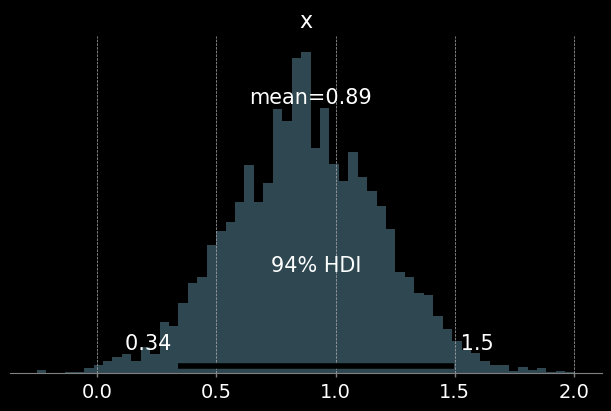

In [40]:
az.plot_posterior(np.array(samples_1), point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
print('The samples mean are: {}'.format(np.mean(samples_1)))

In [41]:
import pymc
# q: Desired quantile to be estimated.
# r: Desired accuracy for quantile.
# s (optional): Probability of attaining the requested accuracy (defaults to 0.95).
pymc.raftery_lewis(np.array(samples_1), q = 0.025, r = 0.005, s = 0.95)
pymc.raftery_lewis(np.array(samples_1), q = 0.005, r = 0.001, s = 0.95)


Raftery-Lewis Diagnostic

3746 iterations required (assuming independence) to achieve 0.005 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

14 iterations to be discarded at the beginning of the simulation (burn-in).

15276 subsequent iterations required.

Thinning factor of 6 required to produce an independence chain.

Raftery-Lewis Diagnostic

19112 iterations required (assuming independence) to achieve 0.001 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

12 iterations to be discarded at the beginning of the simulation (burn-in).

67179 subsequent iterations required.

Thinning factor of 4 required to produce an independence chain.


(19112, 1, 12, 67179, 4)

In the case of the first chain from $samples_1$, it looks like we would need about $3,700$ effective samples to calculate reliable $95\%$ intervals. With the autocorrelation in the chain, that requires about $15,200$ total samples. If we wanted to create reliable $99\%$ intervals, we would need at least $19,100$ total samples.

### 3. Burn-in

We have also seen how the initial value of the chain can affect how quickly the chain converges. If our initial value is far from the bulk of the posterior distribution, then it may take a while for the chain to travel there.

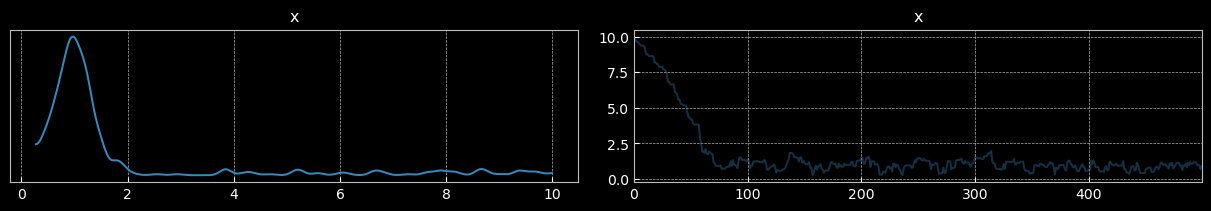

In [42]:
# Burn-in chain
np.random.seed(43) # set the random seed for reproducibility
it = 500
samples_4, aceptance_4 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 10.0, cand_sd = 0.3)

# Plotting the original chain
az.plot_trace(np.array(samples_4))
plt.show()

Clearly, the first $100$ or so iterations do not reflect draws from the stationary distribution, so they should be discarded before we use this chain for Monte Carlo estimates. This is called the “burn-in” period. You should always discard early iterations that do not appear to be coming from the stationary distribution. Even if the chain appears to have converged early on, it is safer practice to discard an initial burn-in.

### Multiple chains, Gelman-Rubin

In [43]:
# Burn-in chain
np.random.seed(43) # set the random seed for reproducibility
it = 500
samples_1, aceptance_1 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 15.0, cand_sd = 0.4)
print('The acceptance rate of chain 1 is: {}'.format(aceptance_1))

samples_2, aceptance_2 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = -5.0, cand_sd = 0.4)
print('The acceptance rate of chain 2 is: {}'.format(aceptance_2))

samples_3, aceptance_3 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 7.0, cand_sd = 0.1)
print('The acceptance rate of chain 3 is: {}'.format(aceptance_3))

samples_4, aceptance_4 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 23.0, cand_sd = 0.5)
print('The acceptance rate of chain 4 is: {}'.format(aceptance_4))

samples_5, aceptance_5 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = -17.0, cand_sd = 0.4)
print('The acceptance rate of chain 5 is: {}'.format(aceptance_5))

The acceptance rate of chain 1 is: 0.63
The acceptance rate of chain 2 is: 0.596
The acceptance rate of chain 3 is: 0.824
The acceptance rate of chain 4 is: 0.536
The acceptance rate of chain 5 is: 0.596


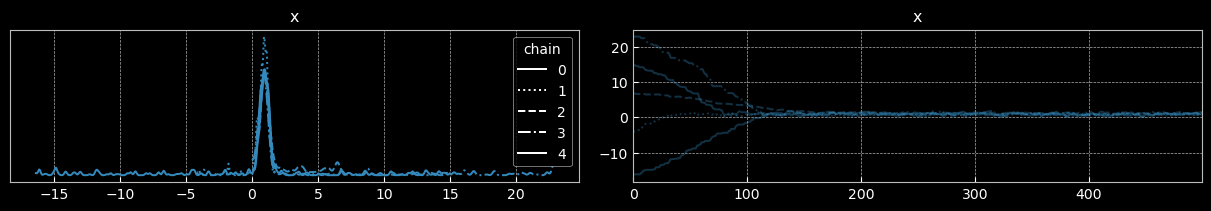

In [44]:
stack_trace = np.vstack((samples_1, samples_2, samples_3, samples_4, samples_5))
az.plot_trace(stack_trace, compact=True, legend=True)
plt.show()

It appears that after about iteration $200$, all chains are exploring the stationary (posterior) distribution. We can back up our visual results with the Gelman and Rubin diagnostic. This diagnostic statistic calculates the variability within chains, comparing that to the variability between chains. If all chains have converged to the stationary distribution, the variability between chains should be relatively small, and the potential scale reduction factor, reported by the the diagnostic, should be close to one. If the values are much higher than one, then we would conclude that the chains have not yet converged.

In [45]:
# Gelman analysis
pymc.gelman_rubin(stack_trace)

1.1236251171848675

### 4. Monte Carlo estimation

If we are reasonably confident that our Markov chain has converged, then we can go ahead and treat it as a Monte Carlo sample from the posterior distribution. Thus, we can use the techniques shown before to calculate posterior quantities like the posterior mean and posterior intervals from the samples directly.

In [46]:
np.random.seed(43) # set the random seed for reproducibility
it = 4000
samples_1, aceptance_1 = random_walk_sampler(n = n, y_bar = y_bar, n_iter = it, mu_init = 15.0, cand_sd = 0.4)
print('The acceptance rate of chain 1 is: {}'.format(aceptance_1))

nburn = 1000 # remember to discard early iterations
samples_1_keep = samples_1[nburn:]
pm.summary(np.array(samples_1_keep))

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
The acceptance rate of chain 1 is: 0.639


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.898,0.323,0.288,1.467,0.016,0.012,432.0,389.0,451.0,487.0,NaN


In [47]:
# Indicator variable
ind = np.array(samples_1_keep) > 1.0
p_1 = np.mean(ind) # posterior probability that mu  > 1.0
print('The probability that P(x > 1.0) = {}'.format(p_1))

The probability that P(x > 1.0) = 0.38066666666666665
